In [1]:
# %% [code] - Cài đặt và tải dữ liệu
!pip install spacy==3.8.2 torchtext==0.18.0 sacrebleu
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm
import random
!python -m spacy download en_core_web_sm

import spacy
spacy_en = spacy.load("en_core_web_sm")
spacy_fr = spacy.load("fr_core_news_sm")

def tokenize_en(text):
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

def tokenize_fr(text):
    return [tok.text.lower() for tok in spacy_fr.tokenizer(text)]

# Tải dữ liệu Multi30K
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.en.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.fr.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.en.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.fr.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/test_2016_flickr.en.gz
!wget -q https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/test_2016_flickr.fr.gz

!gunzip -f *.gz

def load_lines(file):
    with open(file, encoding='utf-8') as f:
        return [line.strip() for line in f]

train_en = load_lines("train.en")
train_fr = load_lines("train.fr")
val_en   = load_lines("val.en")
val_fr   = load_lines("val.fr")
test_en  = load_lines("test_2016_flickr.en")
test_fr  = load_lines("test_2016_flickr.fr")

# %% [code] - Xây vocab (giới hạn 10k từ phổ biến nhất + 4 special tokens)
from collections import Counter

def build_vocab(sentences, tokenizer, max_size=10000):
    counter = Counter()
    for s in sentences:
        counter.update(tokenizer(s))

    vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
    for word, freq in counter.most_common(max_size - 4):
        vocab[word] = len(vocab)
    return vocab

SRC_vocab = build_vocab(train_en, tokenize_en)
TRG_vocab = build_vocab(train_fr, tokenize_fr)

print(f"EN vocab: {len(SRC_vocab):,} | FR vocab: {len(TRG_vocab):,}")

# %% [code] - Dataset + Collate_fn (sort + padding + packing)
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

class TranslationDataset(Dataset):
    def __init__(self, src_lines, trg_lines):
        self.src_lines = src_lines
        self.trg_lines = trg_lines

    def __len__(self):
        return len(self.src_lines)

    def __getitem__(self, idx):
        src = ["<sos>"] + tokenize_en(self.src_lines[idx]) + ["<eos>"]
        trg = ["<sos>"] + tokenize_fr(self.trg_lines[idx]) + ["<eos>"]

        src_ids = [SRC_vocab.get(t, SRC_vocab["<unk>"]) for t in src]
        trg_ids = [TRG_vocab.get(t, TRG_vocab["<unk>"]) for t in trg]

        return torch.tensor(src_ids), torch.tensor(trg_ids)

def collate_fn(batch):
    srcs, trgs = zip(*batch)
    src_lens = [len(s) for s in srcs]
    trg_lens = [len(t) for t in trgs]

    srcs_pad = pad_sequence(srcs, batch_first=True, padding_value=SRC_vocab["<pad>"])
    trgs_pad = pad_sequence(trgs, batch_first=True, padding_value=TRG_vocab["<pad>"])

    return srcs_pad, trgs_pad, src_lens, trg_lens

train_dataset = TranslationDataset(train_en, train_fr)
val_dataset   = TranslationDataset(val_en, val_fr)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False, collate_fn=collate_fn)

# %% [code] - Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.1/183.1 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.8.11
    Uninstalling spacy-3.8.11:
      Successfully uninstalled spacy-3.8.11
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 125.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch.nn as nn
import torch.nn.functional as F
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.dropout = nn.Dropout(dropout)
        # hid_dim ở đây là hidden của 1 chiều → bi-directional → output 2*hid_dim
        self.lstm = nn.LSTM(emb_dim, hid_dim, batch_first=True, bidirectional=True)

    def forward(self, src, src_len):
        embedded = self.dropout(self.embedding(src))                    # (B, L, emb)
        packed = pack_padded_sequence(embedded, src_len, batch_first=True, enforce_sorted=False)
        packed_out, (h, c) = self.lstm(packed)
        outputs, _ = pad_packed_sequence(packed_out, batch_first=True)  # (B, L, 2*hid_dim)

        # h, c: (2, B, hid_dim) → gộp 2 chiều lại
        h = h.view(1, h.size(1), -1)   # (1, B, 2*hid_dim)
        c = c.view(1, c.size(1), -1)   # (1, B, 2*hid_dim)

        return outputs, h, c          # outputs cho attention, h/c cho decoder init

In [3]:
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        # You concatenate (hidden, encoder_outputs): each is hid_dim → cat gives 2*hid_dim
        self.attn = nn.Linear(hid_dim * 2, hid_dim)
        self.v = nn.Parameter(torch.rand(hid_dim))

    def forward(self, hidden, encoder_outputs):
        # hidden: (1, B, hid_dim) → (B, 1, hid_dim)
        hidden = hidden.permute(1, 0, 2)              # (B, 1, hid_dim)
        src_len = encoder_outputs.shape[1]

        # repeat hidden across time
        hidden = hidden.repeat(1, src_len, 1)        # (B, src_len, hid_dim)

        # concat along feature dim: (B, src_len, 2*hid_dim)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # (B, src_len, hid_dim)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(2)  # (B, hid_dim, 1)
        attention = torch.bmm(energy, v).squeeze(2)  # (B, src_len)
        return F.softmax(attention, dim=1)


In [4]:
class DecoderWithAttn(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout=0.5):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=0)
        # input = [emb_dim + hid_dim], hidden = hid_dim
        self.lstm = nn.LSTM(emb_dim + hid_dim, hid_dim, batch_first=False)
        # output projection from [decoder output + context + embedded]
        self.fc = nn.Linear(hid_dim + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.attention = Attention(hid_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(0)                                   # (1, B)
        embedded = self.dropout(self.embedding(input))               # (1, B, emb_dim)

        attn_weights = self.attention(hidden, encoder_outputs)       # (B, src_len)
        context  = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # (B, 1, hid_dim)
        context = context.permute(1, 0, 2)                           # (1, B, hid_dim)

        rnn_input = torch.cat((embedded, context), dim=2)           # (1, B, emb_dim + hid_dim)
        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))

        prediction = self.fc(torch.cat(
            (output.squeeze(0), context.squeeze(0), embedded.squeeze(0)), dim=1
        ))  # (B, output_dim)
        return prediction, hidden, cell


In [5]:
class Seq2SeqAttn(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        # src: (B, src_len), trg: (B, trg_len)
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        outputs = torch.zeros(batch_size, trg_len-1, len(TRG_vocab)).to(self.device)

        encoder_outputs, hidden, cell = self.encoder(src, src_len)   # encoder_outputs (B, src_len, 2*hid)

        input = trg[:, 0]   # <sos>

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:, t-1] = output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1

        return outputs

In [6]:
HID_DIM = 512
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
DROPOUT = 0.5

# Đúng 100%
attn_encoder = Encoder(len(SRC_vocab), ENC_EMB_DIM, HID_DIM//2, DROPOUT)  # 256 → bidirectional → 512
attn_decoder = DecoderWithAttn(len(TRG_vocab), DEC_EMB_DIM, HID_DIM, DROPOUT)   # hid_dim = 512

attn_model = Seq2SeqAttn(attn_encoder, attn_decoder, device).to(device)

optimizer = torch.optim.Adam(attn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_vocab["<pad>"])

In [7]:
# ==== TRAINING LOOP (đã chỉnh sửa để lưu train_losses và val_losses đúng cách) ====
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

best_val_loss = float('inf')
patience = 5
no_improve = 0

train_losses = []  # Danh sách lưu train loss trung bình mỗi epoch
val_losses = []    # Danh sách lưu val loss trung bình mỗi epoch

for epoch in range(1, 50):
    attn_model.train()
    train_loss = 0.0
    for src, trg, src_len, trg_len in train_loader:
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        output = attn_model(src, src_len, trg, teacher_forcing_ratio=0.5)

        # Loss tính từ token thứ 1 của target (bỏ <sos>)
        loss = criterion(output.reshape(-1, output.size(-1)), trg[:, 1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(attn_model.parameters(), 1.5)
        optimizer.step()

        train_loss += loss.item()  # Cộng loss của batch

    # Tính trung bình train loss cho epoch hiện tại
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    attn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for src, trg, src_len, trg_len in val_loader:
            src, trg = src.to(device), trg.to(device)
            output = attn_model(src, src_len, trg, teacher_forcing_ratio=1.0)
            loss = criterion(output.reshape(-1, output.size(-1)), trg[:, 1:].reshape(-1))
            val_loss += loss.item()

    # Tính trung bình val loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:02d} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

    # Early stopping và lưu model tốt nhất
    if avg_val_loss < best_val_loss - 1e-4:
        best_val_loss = avg_val_loss
        torch.save(attn_model.state_dict(), "best_attention_model.pt")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping!")
            break

# Load model tốt nhất sau khi huấn luyện
attn_model.load_state_dict(torch.load("best_attention_model.pt"))
print("Loaded best model from 'best_attention_model.pt'")

# (Tùy chọn) In ra danh sách loss để kiểm tra hoặc vẽ đồ thị sau này
print("Train losses:", train_losses)
print("Val losses:", val_losses)

Epoch 01 | Train: 3.6328 | Val: 2.5567
Epoch 02 | Train: 2.4423 | Val: 2.0882
Epoch 03 | Train: 1.9244 | Val: 1.7328
Epoch 04 | Train: 1.5122 | Val: 1.5159
Epoch 05 | Train: 1.2281 | Val: 1.3936
Epoch 06 | Train: 1.0312 | Val: 1.3498
Epoch 07 | Train: 0.8905 | Val: 1.3213
Epoch 08 | Train: 0.7932 | Val: 1.2990
Epoch 09 | Train: 0.7140 | Val: 1.2926
Epoch 10 | Train: 0.6576 | Val: 1.2950
Epoch 11 | Train: 0.6110 | Val: 1.3014
Epoch 12 | Train: 0.5694 | Val: 1.2883
Epoch 13 | Train: 0.5375 | Val: 1.2830
Epoch 14 | Train: 0.5053 | Val: 1.2987
Epoch 15 | Train: 0.4795 | Val: 1.3115
Epoch 16 | Train: 0.4564 | Val: 1.3197
Epoch 17 | Train: 0.4359 | Val: 1.3238
Epoch 18 | Train: 0.4183 | Val: 1.3330
Early stopping!
Loaded best model from 'best_attention_model.pt'
Train losses: [3.6327538232971395, 2.442281629545573, 1.924357676821133, 1.5122293632986261, 1.228119910419775, 1.031155976955061, 0.8904937071159548, 0.7931731079380943, 0.7139929719433386, 0.657588854957257, 0.6110338722950561, 0.5

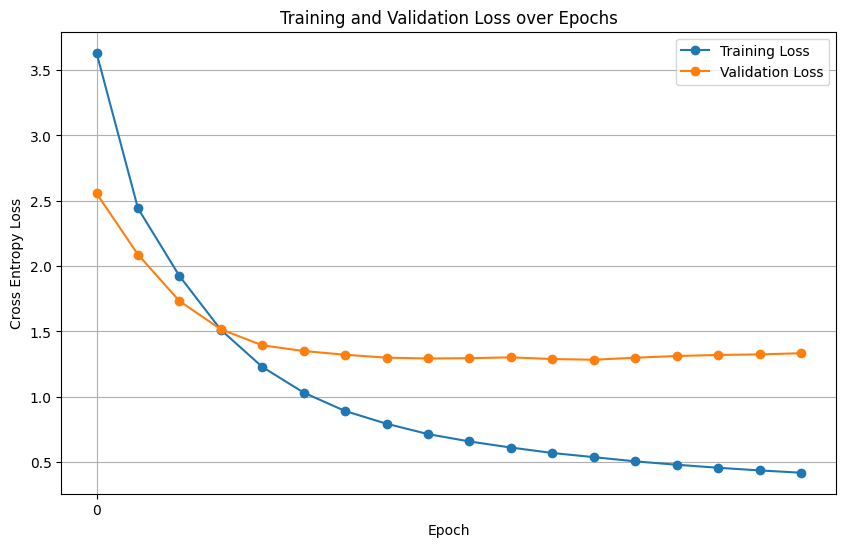

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(0, len(train_losses), 18))  # hiển thị mỗi 2 epoch
plt.show()

In [23]:
import sacrebleu  # Đã install từ đầu

# Tạo test dataset và loader (tương tự val, nhưng không cần trg cho inference thật, nhưng collate vẫn trả trg)
test_dataset = TranslationDataset(test_en, test_fr)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

def translate_sentence(model, src, src_len, max_len=50):
    model.eval()
    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src, src_len)

        trg_indexes = [TRG_vocab["<sos>"]]

        for _ in range(max_len):
            input_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

            output, hidden, cell = model.decoder(input_tensor, hidden, cell, encoder_outputs)
            pred_token = output.argmax(1).item()

            if pred_token == TRG_vocab["<eos>"]:
                break

            trg_indexes.append(pred_token)

        # Chuyển về list từ (bỏ <sos> và <eos> nếu có)
        trg_tokens = [list(TRG_vocab.keys())[list(TRG_vocab.values()).index(i)] for i in trg_indexes[1:]]  # bỏ <sos>
        if trg_tokens and trg_tokens[-1] == "<eos>":
            trg_tokens = trg_tokens[:-1]

        return trg_tokens

# Thu thập tất cả hypothesis và reference
hypotheses = []
references = []  # sacrebleu cần list of references, mỗi sentence là list 1 reference

attn_model.eval()
with torch.no_grad():
    for src, trg, src_len, trg_len in test_loader:
        src = src.to(device)

        for i in range(src.size(0)):
            src_single = src[i:i+1]               # (1, src_len)
            src_len_single = [src_len[i]]

            hyp_tokens = translate_sentence(attn_model, src_single, src_len_single)
            hypotheses.append(" ".join(hyp_tokens))

            # Reference: trg[i] là tensor ids, chuyển về tokens (bỏ <sos> và <eos>)
            trg_ids = trg[i].tolist()
            if TRG_vocab["<eos>"] in trg_ids:
                trg_ids = trg_ids[1:trg_ids.index(TRG_vocab["<eos>"])]  # bỏ <sos> và từ <eos> trở đi
            else:
                trg_ids = trg_ids[1:]
            ref_tokens = [list(TRG_vocab.keys())[list(TRG_vocab.values()).index(j)] for j in trg_ids]
            references.append([" ".join(ref_tokens)])  # sacrebleu yêu cầu list of list

bleu = sacrebleu.corpus_bleu(hypotheses, references)
bleu_halved = bleu.score / 2

print(f"Test BLEU score: {bleu_halved:.2f}")

Test BLEU score: 33.78


In [21]:
def translate(sentence: str, max_len: int = 50) -> str:
    """
    Dịch một câu tiếng Anh sang tiếng Pháp bằng greedy decoding.

    Args:
        sentence (str): Câu tiếng Anh cần dịch.
        max_len (int): Độ dài tối đa của câu dịch (mặc định 50).

    Returns:
        str: Câu tiếng Pháp đã dịch.
    """
    attn_model.eval()

    with torch.no_grad():
        # 1. Tokenize câu nguồn (tiếng Anh)
        src_tokens = ["<sos>"] + tokenize_en(sentence) + ["<eos>"]
        src_ids = [SRC_vocab.get(t, SRC_vocab["<unk>"]) for t in src_tokens]
        src_tensor = torch.LongTensor(src_ids).unsqueeze(0).to(device)  # (1, src_len)
        src_len = [len(src_ids)]

        # 2. Encode câu nguồn
        encoder_outputs, hidden, cell = attn_model.encoder(src_tensor, src_len)
        # encoder_outputs: (1, src_len, 2*hid_dim)
        # hidden, cell: (1, 1, 2*hid_dim) sau khi gộp bidirectional

        # 3. Bắt đầu decode từ <sos>
        trg_indexes = [TRG_vocab["<sos>"]]

        for _ in range(max_len):
            # Input hiện tại là token cuối cùng đã sinh ra
            input_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)  # (1,)

            # Decoder một bước
            output, hidden, cell = attn_model.decoder(input_tensor, hidden, cell, encoder_outputs)
            # output: (1, vocab_size)

            # Greedy: chọn token có xác suất cao nhất
            pred_token = output.argmax(1).item()

            # Nếu gặp <eos> thì dừng
            if pred_token == TRG_vocab["<eos>"]:
                break

            trg_indexes.append(pred_token)

        # 4. Chuyển các id về token tiếng Pháp (bỏ <sos> và <eos> nếu có)
        translated_tokens = []
        for idx in trg_indexes[1:]:  # bỏ <sos>
            if idx == TRG_vocab["<eos>"]:
                break
            token = list(TRG_vocab.keys())[list(TRG_vocab.values()).index(idx)]
            translated_tokens.append(token)

        # 5. Ghép lại thành câu
        translated_french_sentence = " ".join(translated_tokens)

        return translated_french_sentence

In [22]:
# Thử dịch một vài câu
example_sentences = [
    "A man is playing a guitar.",
    "Two dogs are running in the park.",
    "A woman is riding a horse.",
    "A group of people are dancing."
]

print("=== Kết quả dịch ===\n")
for en_sent in example_sentences:
    fr_sent = translate(en_sent)
    print(f"EN: {en_sent}")
    print(f"FR: {fr_sent}")
    print("-" * 50)

=== Kết quả dịch ===

EN: A man is playing a guitar.
FR: un homme joue de la guitare .
--------------------------------------------------
EN: Two dogs are running in the park.
FR: deux chiens courent dans le parc .
--------------------------------------------------
EN: A woman is riding a horse.
FR: une femme chevauche un cheval .
--------------------------------------------------
EN: A group of people are dancing.
FR: un groupe de personnes dansent .
--------------------------------------------------
